# Trabajo práctico - Aprendizaje Automático I

Vamos a trabajar con el dataset `weatherAUS.csv` que contiene información sobre el clima de Australia en los últimos diez años. El objetivo es usar la información del dataset para predecir los atributos `RainTomorrow` y `RainfallTomorrow` con nuevos datos. Para esto vamos a utilizar modelos de regresión lineal, regresión logística y redes neuronales.

# Análisis exploratorio y limpieza de datos

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

In [2]:
df_original = pd.read_csv('datasets/weatherAUS.csv', index_col=0)

# Columnas

* **Sunshine:** Numero de horas de sol en el dia
* **Rainfall:** Cantidad de lluvia en el dia en mm
* **Evaporation:** La denominada evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
* **WindGustDir:** La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche
* **WindGustSpeed:** La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas previas a la medianoche
* **WindDir9am:** Dirección del viento a las 9 a.m.
* **WindDir3pm:** direccion del viento alas 3pm
* **WindSpeed9am:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 9 a.m.
* **WindSpeed3pm:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 3 p.m.
* **Humidity9am:** Humedad (porcentaje) a las 09:00 horas.
* **Humidity3pm:** Humedad (porcentaje) a las 15:00 horas.
* **Pressure9am:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 9 a.m.
* **Pressure3pm:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 3 p.m.
* **Cloud9am:** Fracción del cielo oscurecida por las nubes a las 9:00 horas. Esto se mide en "oktas", que son una unidad de octavos. Registra cuántas octavas partes del cielo están oscurecidas por las nubes. Una medida 0 indica cielo completamente despejado mientras que un 8 indica que está completamente nublado.
* **Cloud3pm:**
* **Temp9am:** Temperatura (grados C) a las 9 a.m.
* **Temp3pm:**
* **RainToday:** Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
* **RainTomorrow:** La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".
* **RainfallTomorrow:** Variable booleana, indica si el día siguiente va a llover o no.

Para entrenar los modelos solamente vamos a usar cinco ciudades del dataset

In [4]:
ciudades = ['Sydney',
            'SydneyAirport',
            'Canberra',
            'Melbourne',
            'MelbourneAirport']

df = df_original[df_original['Location']\
                 .isin(ciudades)]\
                 .copy()\
                 .reset_index(drop=True)

Ordenamos el dataframe por localidad y fecha porque vamos a usar el metodo de la interpolacion lienal para llenar valores faltantes y tambien el metodo de valor mas cercano valido. 

In [5]:
df.sort_values(['Location', 'Date'], inplace=True)

Imputamos los datos que no son medidas estadicas antes de separar el dataset

## MinTemp y MaxTemp

Para estas variables decidimos usar una interpolación, ya que la temperatura de los días faltantes probablemente se encuentre en algún punto entre la temperatura del día anterior y la del día posterior.

In [6]:
df['MinTemp'].interpolate(method='linear', inplace=True)
df['MaxTemp'].interpolate(method='linear', inplace=True)

## WindDir 

Para la direcciones viento elegimos llenarla con el valor siguiente válido ya que es dataset está ordenado por fecha.

In [7]:
df['WindDir9am'].fillna(method='ffill', inplace=True)
df['WindDir3pm'].fillna(method='ffill', inplace=True)

## RainToday y RainTomorrow

Los valores Nan de estas dos variables son muy pocos y difíciles de imputar por eso decidimos eliminarlos.

In [8]:
df.RainToday.isna().sum(), df.RainTomorrow.isna().sum()

(787, 787)

In [9]:
df.dropna(subset=['RainTomorrow'], inplace=True)
df.dropna(subset=['RainToday'], inplace=True)

# Split del dataset

Separamos el dataset para en entrenamiento y prueba

In [10]:
x_reg = df.drop(columns=['RainTomorrow', 'RainfallTomorrow'])
y_reg = df['RainfallTomorrow']

x_clas = x_reg
y_clas = df['RainTomorrow']

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=42)
x_train_clas, x_test_clas, y_train_clas, y_test_clas = train_test_split(x_clas, y_clas, test_size=0.2, random_state=42)

In [11]:
df_reg  = pd.concat([x_train_reg, y_train_reg], axis=1)
df_clas = pd.concat([x_train_clas, y_train_clas], axis=1)

# ¿Está balanceado el dataset?

### Dataset regresión

El dataset no está balanceado porque la variable independietne que queremos predecir tiene muchos valores iguales a $0$.

<Axes: >

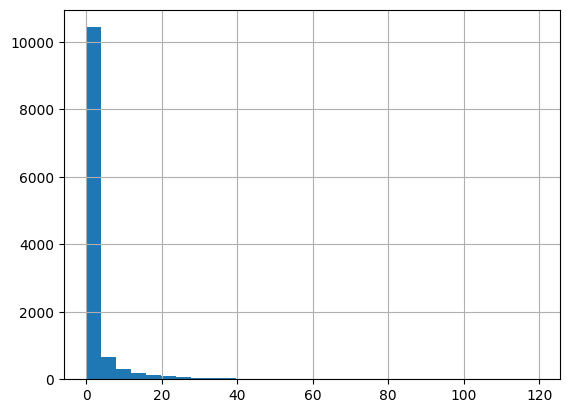

In [216]:
y_train_reg.hist(bins=30)

In [217]:
y_train_reg.shape

(12028,)

In [218]:
y_train_reg.value_counts()

RainfallTomorrow
0.0     7743
0.2      666
0.4      327
0.6      231
0.8      152
        ... 
41.8       1
54.4       1
40.6       1
57.8       1
53.0       1
Name: count, Length: 261, dtype: int64

In [219]:
f'{7784/12788:.2f}'

'0.61'

En el histograma vemos gráficamente que el dataset está desbalanceado, ya que la moda es $0$ y con los valores vemos que aproximadamente el $61\%$ de los valores de la variable a predecir son $0$.

### Dataset clasificación

<Axes: >

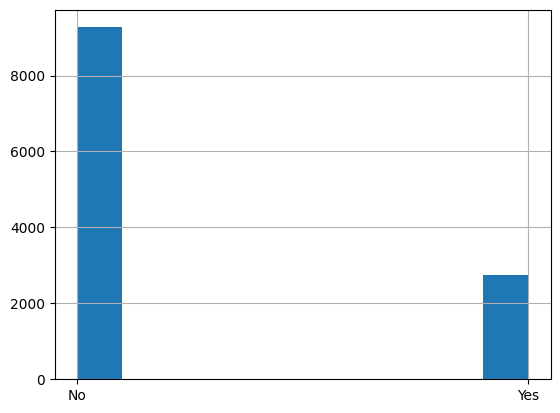

In [220]:
y_train_clas.hist()

In [221]:
y_train_clas.shape

(12028,)

In [222]:
y_train_clas.value_counts()

RainTomorrow
No     9270
Yes    2758
Name: count, dtype: int64

In [223]:
f'{9337/12788:.2f}'

'0.73'

Para el caso del dataset que usaremos para la clasificación también vemos que hay un importante desbalanceo, ya que el $73\%$ de sus valores pertenecen a una de las clases.

# Imputación de datos

## WindGustDir 

Esta variable en un momento habíamos decidido eliminarla (tenía un años con valores `nan`) pero ahora creemos que es mejor llenarla con la moda en función a la localidad y estación del año. 

In [12]:
df_modelos = [df_reg, df_clas, x_test_reg, x_test_clas]

def agregar_fecha(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Month'] = dataframe['Date'].dt.month

for dataframe in df_modelos:
    agregar_fecha(dataframe)

Estaciones en Australia
- Otoño: del 1 de marzo al 31 de mayo
- Invierno: del 1 de junio al 31 de agosto
- Primavera: del 1 de septiembre al 30 de noviembre
- Verano: del 1 de diciembre al 28 (ó 29) de febrero

In [13]:
estaciones_dict = {1:  'Verano',
                   2:  'Verano',
                   3:  'Otoño',
                   4:  'Otoño',
                   5:  'Otoño',
                   6:  'Invierno',
                   7:  'Invierno',
                   8:  'Invierno',
                   9:  'Primavera',
                   10: 'Primavera',
                   11: 'Primavera',
                   12: 'Verano'}

for dataframe in df_modelos:
    dataframe['Estacion'] = dataframe['Month'].map(estaciones_dict)
    
# df_reg['Estacion']  = df_reg['Month'].map(estaciones_dict)
# df_clas['Estacion'] = df_reg['Month'].map(estaciones_dict)

In [14]:
def temporada_ubicacion(df, columna_a_rellenar, columna_ubicacion, columna_temporada):
    
    moda_por_ubicacion_temporada = df.groupby([columna_ubicacion, columna_temporada])[columna_a_rellenar]\
                                     .apply(lambda x: x.mode().iloc[0])

    df[columna_a_rellenar] = df.apply(
        lambda fila: moda_por_ubicacion_temporada[fila[columna_ubicacion],
                                                  fila[columna_temporada]] 
                                                if pd.isna(fila[columna_a_rellenar]) 
                                                else fila[columna_a_rellenar],
        axis=1)

    return df

In [15]:
for dataframe in df_modelos:
    dataframe = temporada_ubicacion(dataframe, 
                                    'WindGustDir',
                                    'Location',
                                    'Estacion')

# df_reg  = temporada_ubicacion(df_reg,  'WindGustDir', 'Location', 'Estacion')
# df_clas = temporada_ubicacion(df_clas, 'WindGustDir', 'Location', 'Estacion')

In [229]:
for dataframe in df_modelos:
    dataframe['WindGustDir'] = dataframe['WindGustDir'].str[0]
    dataframe['WindDir9am'] = dataframe['WindDir9am'].str[0]
    dataframe['WindDir3pm'] = dataframe['WindDir3pm'].str[0]

# df_reg['WindGustDir']  = df_reg['WindGustDir'].str[0]
# df_reg['WindDir9am']   = df_reg['WindDir9am'].str[0]
# df_reg['WindDir3pm']   = df_reg['WindDir3pm'].str[0]

# df_clas['WindGustDir']  = df_clas['WindGustDir'].str[0]
# df_clas['WindDir9am']   = df_clas['WindDir9am'].str[0]
# df_clas['WindDir3pm']   = df_clas['WindDir3pm'].str[0]

## Rainfall

Para completar la variable `Rainfall` vamos a usar la moda de la distribución que es `0.0`, eso lo podemos comprobar con el siguiente histograma y loop.

Text(0.5, 1.0, 'Dataset Clasificación')

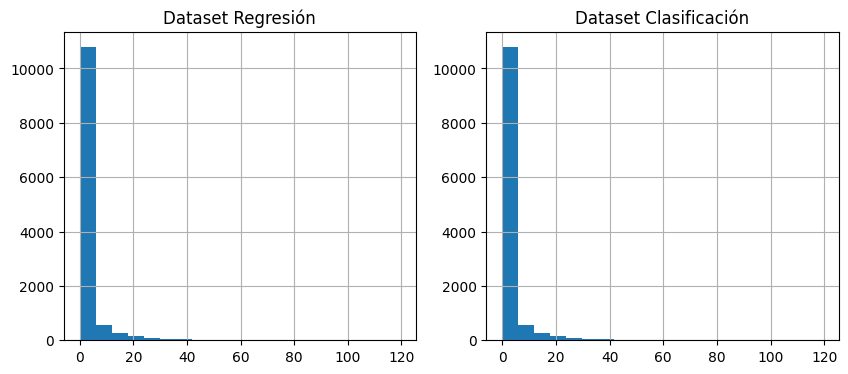

In [230]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Rainfall'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Rainfall'].hist(bins=20)
plt.title('Dataset Clasificación')

In [231]:
for ciudad in ciudades:
    rain = \
        df_reg[df_reg['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [232]:
for ciudad in ciudades:
    rain = \
        df_clas[df_clas['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [233]:
df_reg['Rainfall'].fillna(0.0, inplace=True)
df_clas['Rainfall'].fillna(0.0, inplace=True)

## Evaporation

En esta variable vemos que la distribución es bastante simétrica, además la media y la mediana tiene valores muy cercanos, en esta caso no hay sesgo, por lo tanto decidimos completar los valores faltante con la media.

Text(0.5, 1.0, 'Dataset Clasificación')

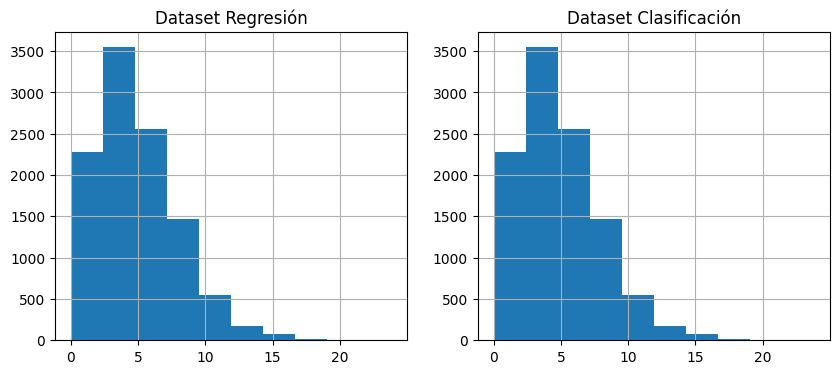

In [234]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Evaporation'].hist()
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Evaporation'].hist()
plt.title('Dataset Clasificación')

In [235]:
df_reg['Evaporation'].mean(), df_reg['Evaporation'].median()

(4.873762051858092, 4.2)

In [236]:
df_clas['Evaporation'].mean(), df_clas['Evaporation'].median()

(4.873762051858092, 4.2)

In [237]:
df_reg['Evaporation'].fillna(df_reg['Evaporation'].mean(), inplace=True)
df_clas['Evaporation'].fillna(df_clas['Evaporation'].mean(), inplace=True)

## Sunshine

En este histograma vemos que la distribución es bimodal, por lo que para imputar los valores faltantes vamos usar la mediana, ya que la media está sesgada por la gran cantidad de `0.0`

Text(0.5, 1.0, 'Dataset Clasificación')

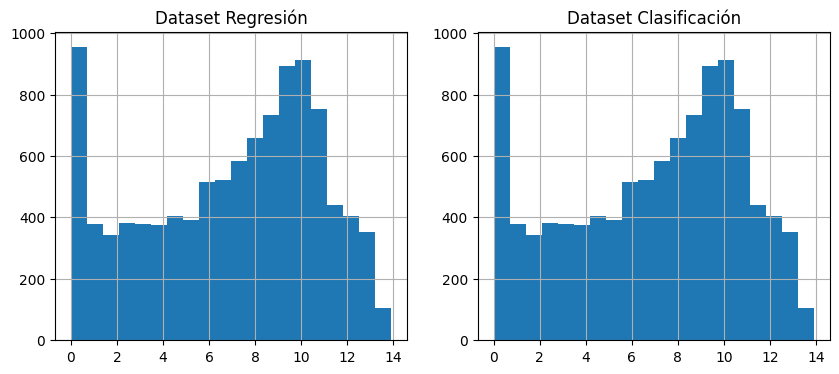

In [238]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Sunshine'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Sunshine'].hist(bins=20)
plt.title('Dataset Clasificación')

In [239]:
df_reg['Sunshine'].fillna(df_reg['Sunshine'].median(), inplace=True)
df_clas['Sunshine'].fillna(df_clas['Sunshine'].median(), inplace=True)

## WindSpeed

En este caso observando los histogramas vemos que podemos completar los valores faltantes con la media.

Text(0.5, 1.0, 'Clasificación - WindSpeed3pm')

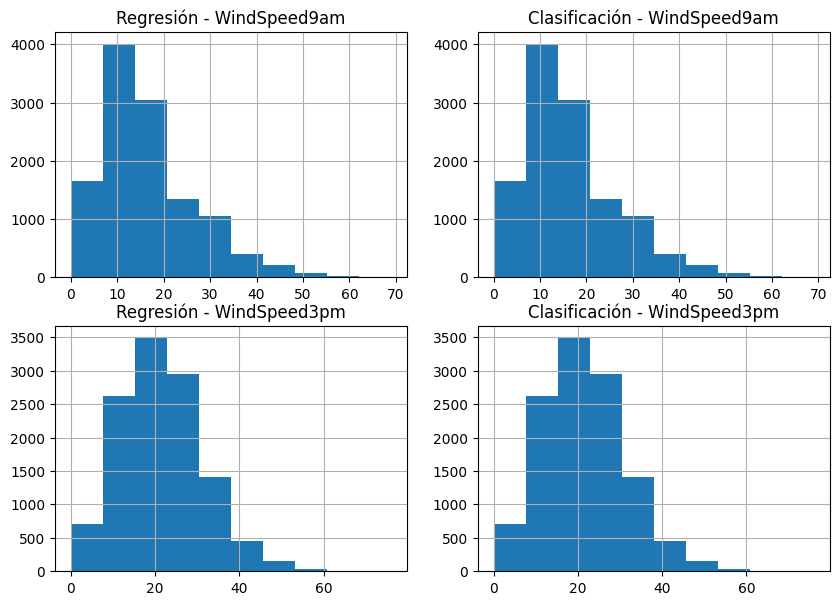

In [240]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['WindSpeed9am'].hist()
plt.title('Regresión - WindSpeed9am')
plt.subplot(222)
df_clas['WindSpeed9am'].hist()
plt.title('Clasificación - WindSpeed9am')
plt.subplot(223)
df_reg['WindSpeed3pm'].hist()
plt.title('Regresión - WindSpeed3pm')
plt.subplot(224)
df_clas['WindSpeed3pm'].hist()
plt.title('Clasificación - WindSpeed3pm')

In [241]:
df_reg['WindSpeed9am'].fillna(df_reg['WindSpeed9am'].mean(),inplace=True)
df_clas['WindSpeed9am'].fillna(df_clas['WindSpeed9am'].mean(),inplace=True)

df_reg['WindSpeed3pm'].fillna(df_reg['WindSpeed3pm'].mean(),inplace=True)
df_clas['WindSpeed3pm'].fillna(df_clas['WindSpeed3pm'].mean(),inplace=True)

## WindSGustSpeed

Vemos que la media y la media son similares esto nos dice que la distribucion es simetrica por lo cual lo llenamos con la mediana

In [242]:
df.WindGustSpeed.describe()

count    13602.000000
mean        44.290619
std         14.948251
min         11.000000
25%         33.000000
50%         43.000000
75%         54.000000
max        122.000000
Name: WindGustSpeed, dtype: float64

In [243]:
df_reg['WindGustSpeed'].fillna(df_reg['WindGustSpeed'].median(), inplace=True)
df_clas['WindGustSpeed'].fillna(df_clas['WindGustSpeed'].median(), inplace=True)

## Humidity

Los valores `nan` de las variables humedad los completamos con la media 

In [244]:
df_reg['Humidity9am'].describe()

count    11961.000000
mean        68.862553
std         15.649308
min         11.000000
25%         59.000000
50%         70.000000
75%         80.000000
max        100.000000
Name: Humidity9am, dtype: float64

Text(0.5, 1.0, 'Clasificación - Humidity3pm')

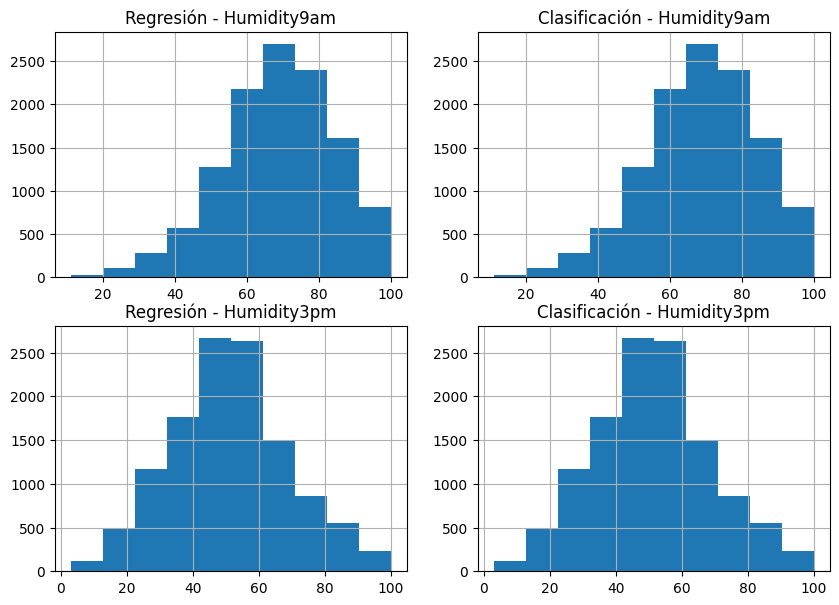

In [245]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Humidity9am'].hist()
plt.title('Regresión - Humidity9am')
plt.subplot(222)
df_clas['Humidity9am'].hist()
plt.title('Clasificación - Humidity9am')
plt.subplot(223)
df_reg['Humidity3pm'].hist()
plt.title('Regresión - Humidity3pm')
plt.subplot(224)
df_clas['Humidity3pm'].hist()
plt.title('Clasificación - Humidity3pm')

In [246]:
df_reg['Humidity9am'].fillna(df_reg['Humidity9am'].mean(),inplace=True)
df_clas['Humidity9am'].fillna(df_reg['Humidity9am'].mean(),inplace=True)

In [247]:
df_clas.Humidity3pm.describe()

count    11988.000000
mean        51.199867
std         17.772806
min          3.000000
25%         39.000000
50%         51.000000
75%         62.000000
max        100.000000
Name: Humidity3pm, dtype: float64

In [248]:
df_clas['Humidity3pm'].fillna(df_clas['Humidity3pm'].mean(), inplace=True)
df_reg['Humidity3pm'].fillna(df_reg['Humidity3pm'].mean(), inplace=True)

## Pressure

Los valores `nan` de esta variables los vamos a llenar con la media. 

Text(0.5, 1.0, 'Clasificación - Pressure3pm')

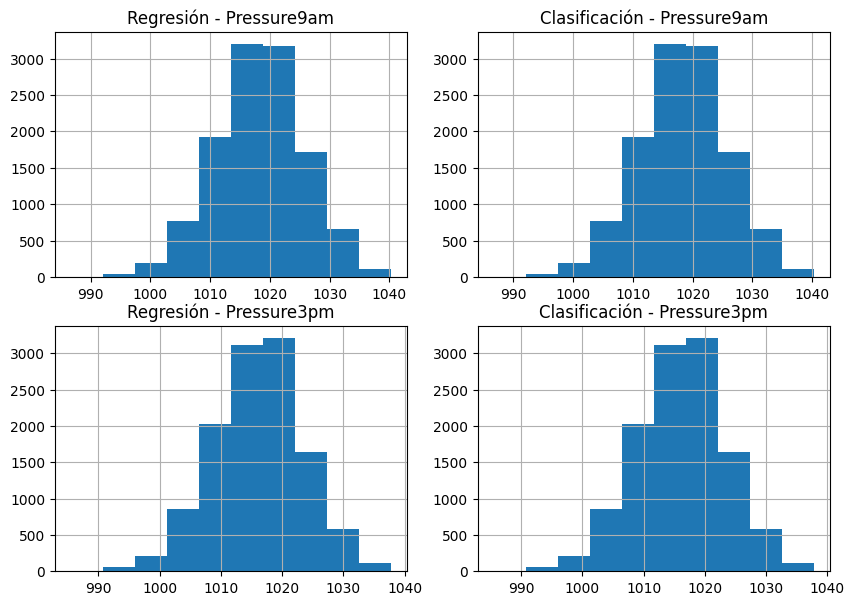

In [249]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Pressure9am'].hist()
plt.title('Regresión - Pressure9am')
plt.subplot(222)
df_clas['Pressure9am'].hist()
plt.title('Clasificación - Pressure9am')
plt.subplot(223)
df_reg['Pressure3pm'].hist()
plt.title('Regresión - Pressure3pm')
plt.subplot(224)
df_clas['Pressure3pm'].hist()
plt.title('Clasificación - Pressure3pm')

In [250]:
df_clas['Pressure3pm'].describe()

count    11823.000000
mean      1016.055453
std          7.277343
min        985.500000
25%       1011.200000
50%       1016.300000
75%       1021.000000
max       1037.800000
Name: Pressure3pm, dtype: float64

In [251]:
df_clas['Pressure9am'].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [252]:
df_reg['Pressure9am'].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [253]:
df_reg['Pressure9am'].fillna(df_reg['Pressure9am'].mean(), inplace=True)
df_reg['Pressure3pm'].fillna(df_reg['Pressure3pm'].mean(), inplace=True)

df_clas['Pressure9am'].fillna(df_clas['Pressure9am'].mean(), inplace=True)
df_clas['Pressure3pm'].fillna(df_clas['Pressure3pm'].mean(), inplace=True)

## Cloud 

Los valores `nan` de esta variable los vamos a llenar con la mediana, ya que en este caso la mediana es mas robusta que el promedio por la distribucion del la variable.

Text(0.5, 1.0, 'Clasificación - Cloud3pm')

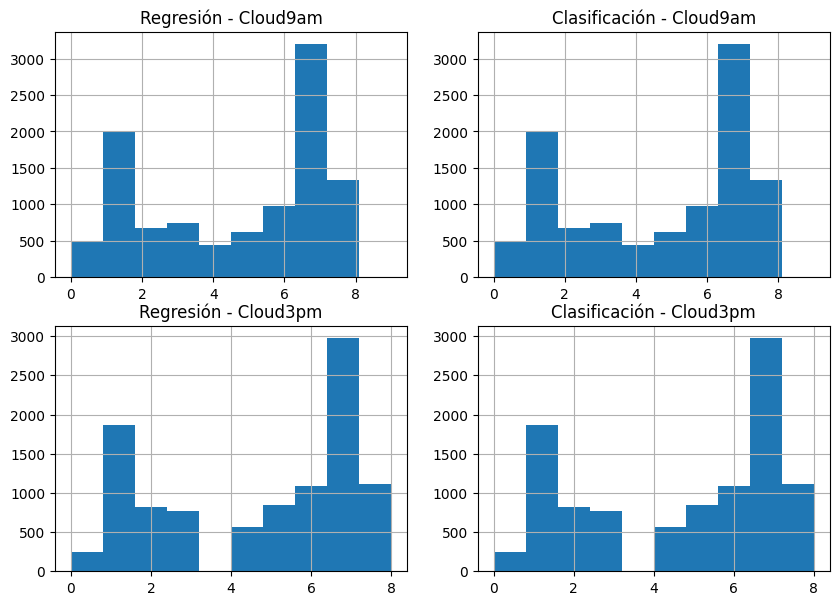

In [254]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Cloud9am'].hist()
plt.title('Regresión - Cloud9am')
plt.subplot(222)
df_clas['Cloud9am'].hist()
plt.title('Clasificación - Cloud9am')
plt.subplot(223)
df_reg['Cloud3pm'].hist()
plt.title('Regresión - Cloud3pm')
plt.subplot(224)
df_clas['Cloud3pm'].hist()
plt.title('Clasificación - Cloud3pm')

In [255]:
df_clas['Cloud3pm'].describe()

count    10287.000000
mean         4.718382
std          2.594606
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Cloud3pm, dtype: float64

In [256]:
df_clas['Cloud9am'].describe()

count    10482.000000
mean         4.721618
std          2.734851
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64

In [257]:
df_clas['Cloud3pm'].fillna(df_clas['Cloud3pm'].median(), inplace=True)
df_clas['Cloud9am'].fillna(df_clas['Cloud9am'].median(), inplace=True)

df_reg['Cloud3pm'].fillna(df_reg['Cloud3pm'].median(), inplace=True)
df_reg['Cloud9am'].fillna(df_reg['Cloud9am'].median(), inplace=True)

## Temp 

Las variables de temperatura de la mañana y tarde seran completadas con el promedio, ya que la distribucion es asimetrica, ademas la media y la media se encuentran muy proximas

Text(0.5, 1.0, 'Clasificación - Temp3pm')

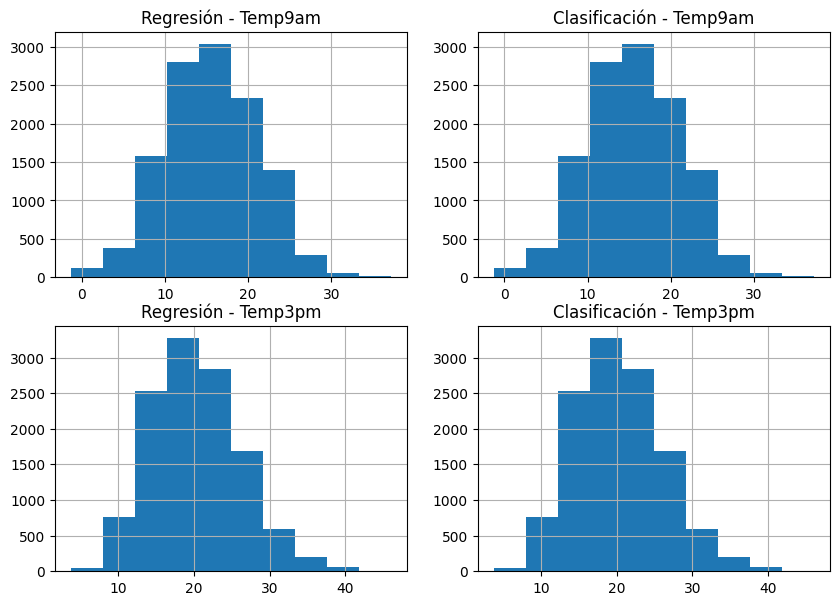

In [258]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Temp9am'].hist()
plt.title('Regresión - Temp9am')
plt.subplot(222)
df_clas['Temp9am'].hist()
plt.title('Clasificación - Temp9am')
plt.subplot(223)
df_reg['Temp3pm'].hist()
plt.title('Regresión - Temp3pm')
plt.subplot(224)
df_clas['Temp3pm'].hist()
plt.title('Clasificación - Temp3pm')

In [259]:
df_reg['Temp3pm'].mean(), df_reg['Temp3pm'].median() 

(20.28962876643915, 19.9)

In [260]:
df_reg['Temp9am'].mean(), df_reg['Temp9am'].median() 

(15.590394539703679, 15.4)

In [261]:
df_reg['Temp9am'].fillna(df_reg['Temp9am'].mean(), inplace=True)
df_reg['Temp3pm'].fillna(df_reg['Temp3pm'].mean(), inplace=True)

df_clas['Temp9am'].fillna(df_clas['Temp9am'].mean(), inplace=True)
df_clas['Temp3pm'].fillna(df_clas['Temp3pm'].mean(), inplace=True)

In [262]:
df_reg.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainfallTomorrow    0
Month               0
Estacion            0
dtype: int64

In [263]:
df_clas.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Month            0
Estacion         0
dtype: int64

# Codificación de variables categóricas

In [264]:
for dataframe in df_modelos:
    dataframe['RainToday'].replace(
                    {'Yes': 1, 'No': 0},
                    inplace=True)

# df_clas['RainToday'] = df_clas['RainToday'].replace({'Yes': 1, 'No': 0})
# df_reg['RainToday']  = df_reg['RainToday'].replace({'Yes': 1, 'No': 0})
# x_test_clas['RainToday']  = x_test_clas['RainToday'].replace({'Yes': 1, 'No': 0})

La variable `RainTomorrow` solo la usamos en el dataset de clasificación, es otro cambio que relizamos porque en los notebook anteriores la habíamos usado en el modelo de regresión lineal y esto nos estaría provocando una fuga de datos.

In [265]:
df_clas['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace=True)
y_test_clas.replace({'Yes': 1, 'No': 0}, inplace=True)

Eliminamos columnas que no vamos a usar

In [266]:
categoricas = ['Location', 'Month', 'Estacion', 'Date']

for dataframe in df_modelos:
    dataframe.drop(columns=categoricas, inplace=True)

# df_clasi = df_clas.drop(columns=categoricas).copy()
# df_regre = df_reg.drop(columns=categoricas).copy()

# x_test_reg.drop(columns=['Location', 'Date'], inplace=True)
# x_test_clas.drop(columns=['Location', 'Date'], inplace=True)

In [267]:
df_reg  = pd.get_dummies(df_reg)
df_clas = pd.get_dummies(df_clas)

x_test_reg  = pd.get_dummies(x_test_reg)
x_test_clas = pd.get_dummies(x_test_reg)

## Imputación en datasets de prueba

Vamos a imputar los datos faltantes en los conjuntos de prueba con el promedio de esa columna en los el conjunto de entrenamiento que ya está imputado.

In [268]:
columnas_numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 
                      'Evaporation', 'Sunshine', 'WindGustSpeed',
                      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                      'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                      'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

promedios_reg  = df_reg[columnas_numericas].mean()
promedios_clas = df_clas[columnas_numericas].mean()

x_test_reg[columnas_numericas] = x_test_reg[columnas_numericas].fillna(promedios_reg)
x_test_clas[columnas_numericas] = x_test_clas[columnas_numericas].fillna(promedios_clas)

# Normalización

In [269]:
scaler = StandardScaler()

for dataframe in df_modelos:
    dataframe[columnas_numericas] = scaler.fit_transform(dataframe[columnas_numericas])

df_reg[columnas_numericas] = scaler.fit_transform(df_reg[columnas_numericas])
df_clas[columnas_numericas] = scaler.fit_transform(df_clas[columnas_numericas])

### Matriz de correlación 

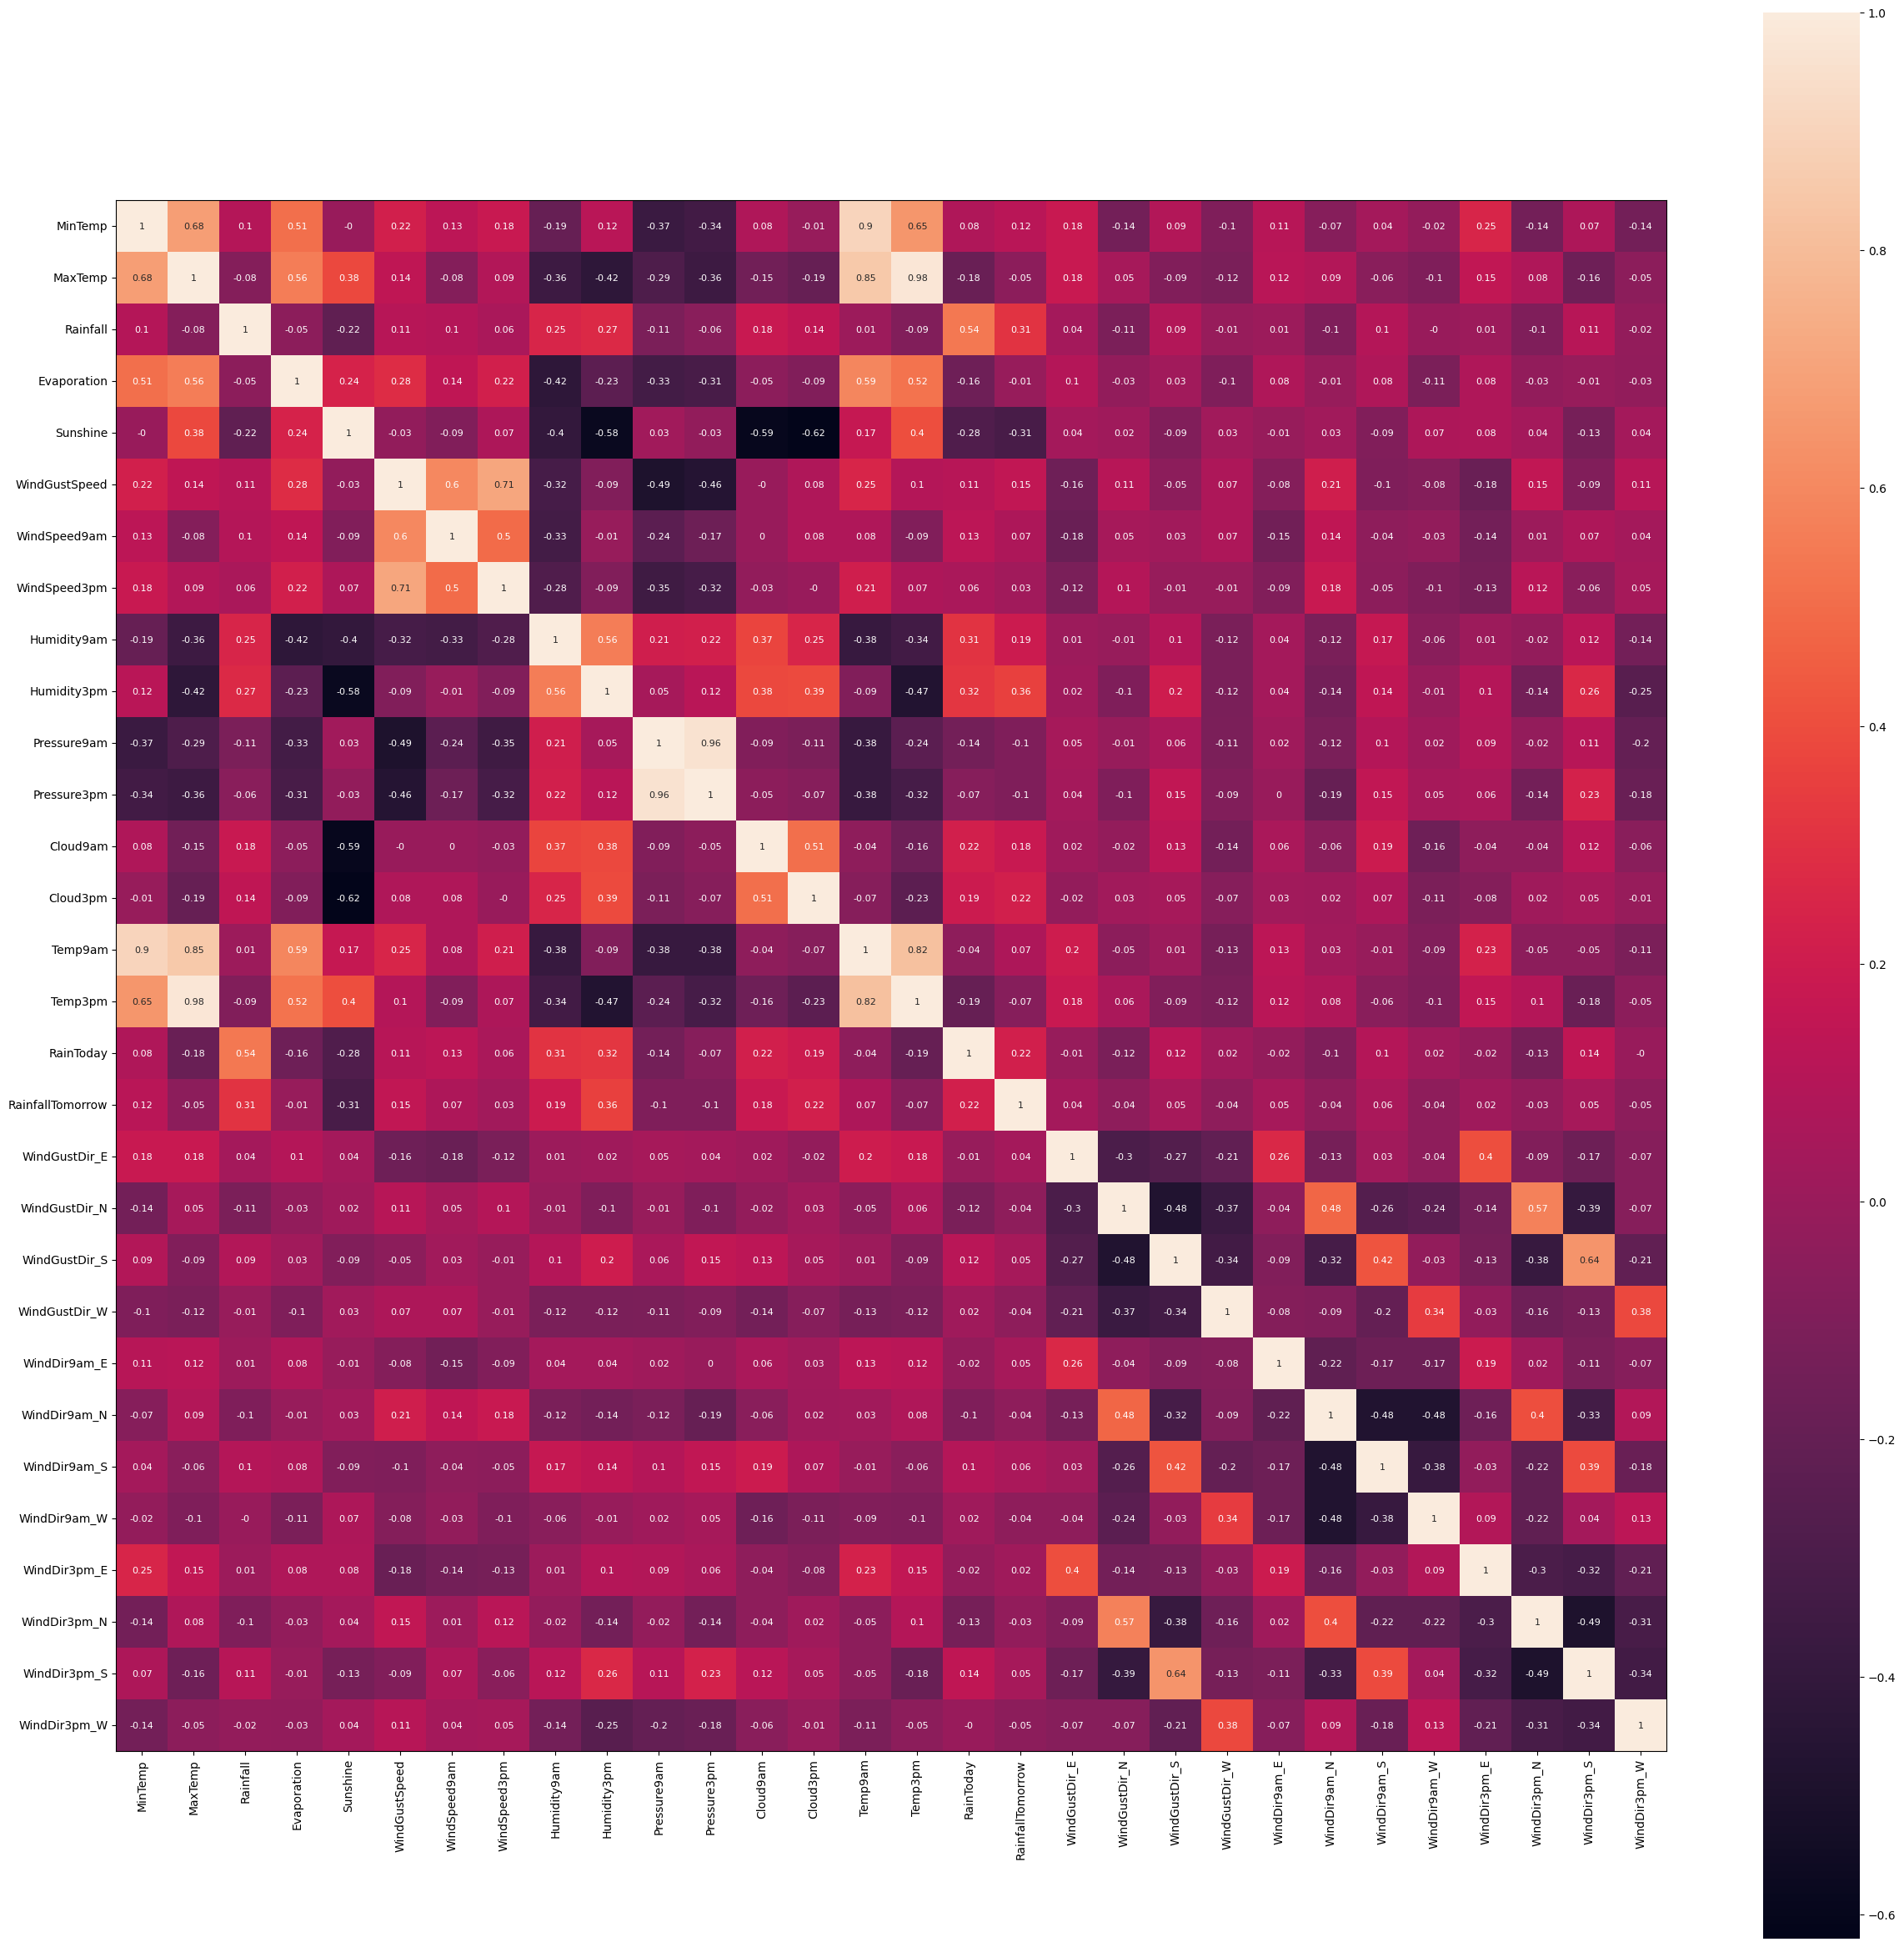

In [270]:
plt.figure(figsize=(30, 30))

heatmap = sns.heatmap(
    df_reg.corr().round(2),
    annot=True,
    square=True,
    annot_kws={'size': 8},  
)

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

En la matriz de correlación podemos qué variables tiene más correlación con la variables objetivos, nos da informaicón sobre relaciones positivas o negativas y el fuerza de cada relación lineal. Consideramos que no debemos eliminar ninguna variable para el entrenamiento de los modelos. 

# Scatter plot entre `RainfallTomorrow` y el resto de variables

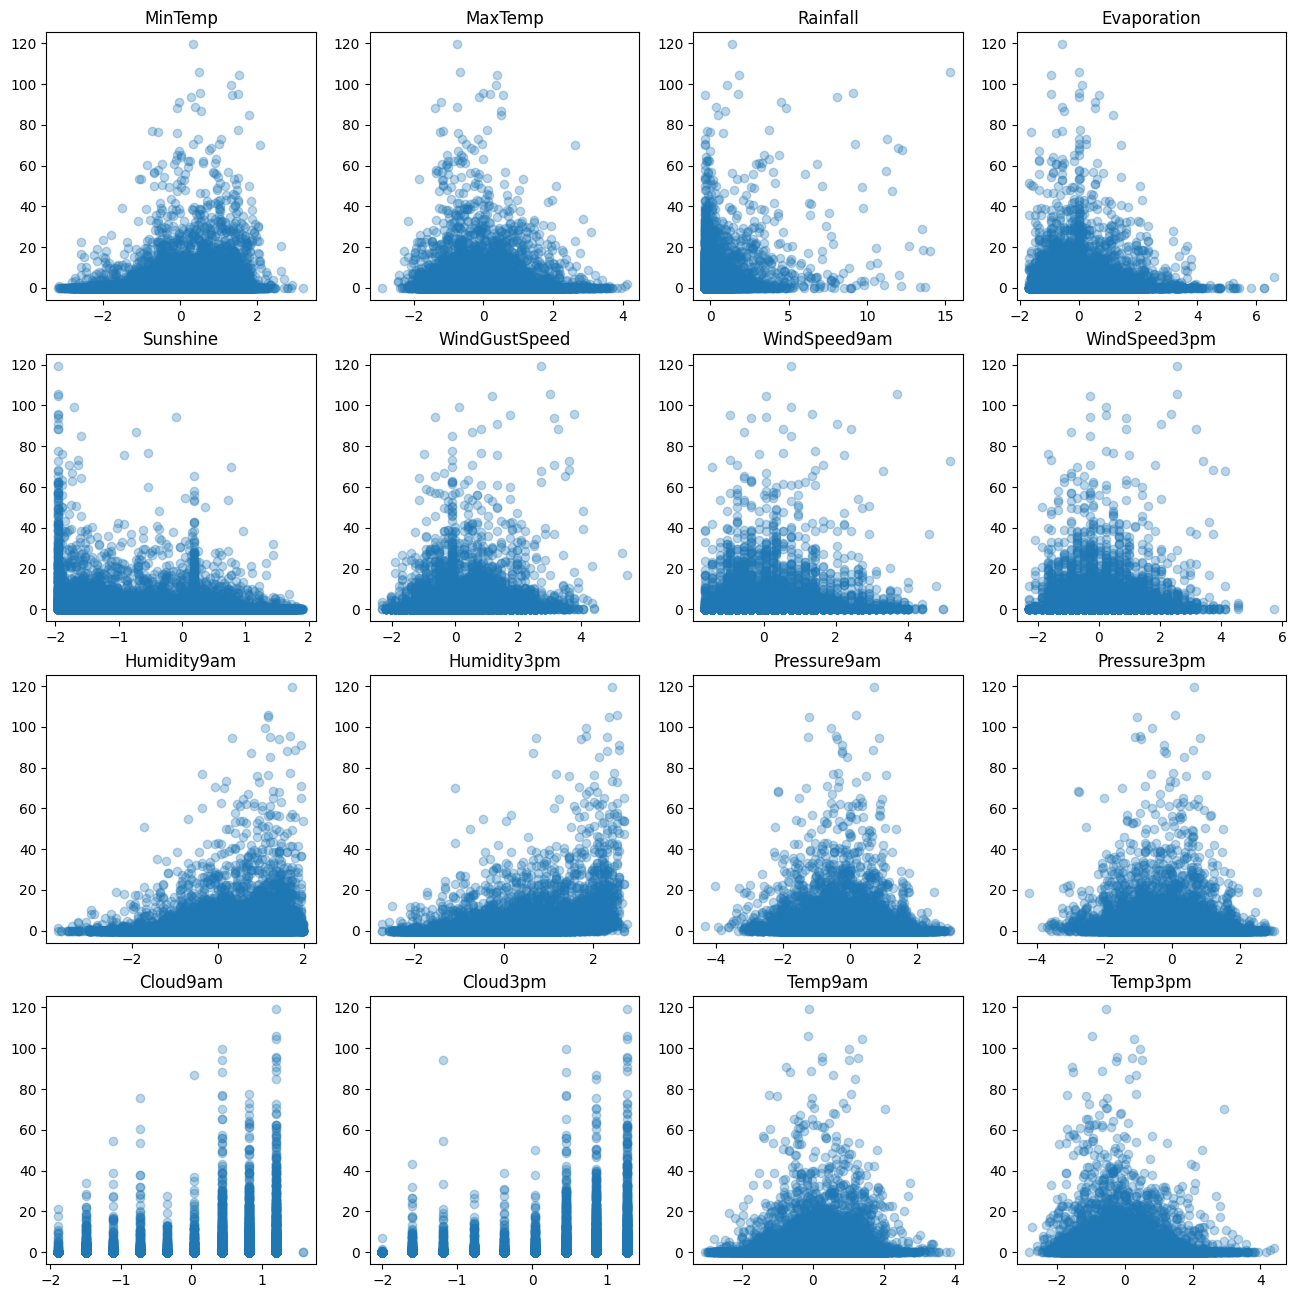

In [271]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_reg.columns[:16], start=1):  
    plt.subplot(4, 4, idx)
    plt.scatter(data=df_reg, x=col, y='RainfallTomorrow', alpha=.3)
    plt.title(col)

De estos gráficos podemos concluir que las variables no tienen una relación lineal con la variable objetivo.

# Dataframes para el entrenamiento

In [272]:
x_train_regre = df_reg.drop(columns=['RainfallTomorrow'])
y_train_regre = df_reg['RainfallTomorrow']  

x_train_clasi = df_clas.drop(columns=['RainTomorrow'])
y_train_clasi = df_clas['RainTomorrow']

# Balanceo del dataset

In [289]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1)

# smote.fit_resample(x_train_reg, y_train_reg)

# Regresión Lineal

In [273]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

def metricas(y_test, y_pred):
    print('R2:   %.2f' % r2_score(y_test, y_pred))
    print('MSE:  %.2f' % mean_squared_error(y_test, y_pred))
    print('RMSE: %.2f' % sqrt(mean_squared_error(y_test, y_pred)))
    print('MAE:  %.2f' % mean_absolute_error(y_test, y_pred))
    print('MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred))

In [287]:
x_train_regre[columnas_numericas].info()

<class 'pandas.core.frame.DataFrame'>
Index: 12028 entries, 10395 to 11358
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        12028 non-null  float64
 1   MaxTemp        12028 non-null  float64
 2   Rainfall       12028 non-null  float64
 3   Evaporation    12028 non-null  float64
 4   Sunshine       12028 non-null  float64
 5   WindGustSpeed  12028 non-null  float64
 6   WindSpeed9am   12028 non-null  float64
 7   WindSpeed3pm   12028 non-null  float64
 8   Humidity9am    12028 non-null  float64
 9   Humidity3pm    12028 non-null  float64
 10  Pressure9am    12028 non-null  float64
 11  Pressure3pm    12028 non-null  float64
 12  Cloud9am       12028 non-null  float64
 13  Cloud3pm       12028 non-null  float64
 14  Temp9am        12028 non-null  float64
 15  Temp3pm        12028 non-null  float64
dtypes: float64(16)
memory usage: 1.6 MB


In [282]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train_regre[columnas_numericas], y_train_regre)

LinearRegression()

In [284]:
y_pred_reg = reg.predict(x_test_reg[columnas_numericas])

In [285]:
metricas(y_test_reg, y_pred_reg)

R2:   -52.80
MSE:  3137.65
RMSE: 56.01
MAE:  42.47
MAPE: 86475152276471504.00


# Regresión logística

In [277]:
from sklearn.linear_model import LogisticRegression
logistica = LogisticRegression()

logistica.fit(x_train_clasi, y_train_clasi)

LogisticRegression()

# Redes neuronales

# Conclusiones finales